In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns
import time

%matplotlib inline

# DNN functions

In [2]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

def deriv_sigmoid(z):  
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return np.tanh(np.clip(z, -250, 250))

def deriv_tanh(z):
    return 1 - tanh(z) ** 2

def relu(z, epsilon=1e-5):
    return np.where(z >= 0, z, 0 + epsilon)

def deriv_relu(z, epsilon=1e-5):
    return np.where(z >= 0, 1, 0 + epsilon)

def logistic_cost(y, y_pred):
    J = - (y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return J

def logistic_grad(y, y_pred, epsilon=1e-3):
    return -(np.divide(y, y_pred + epsilon) - np.divide(1.0 - y, 1.0 - y_pred + epsilon))

def mse(y, y_pred):
    MSE = (y - y_pred) ** 2
    return MSE

def mse_grad(y, y_pred):
    return y - y_pred

# Auxiliar functions

In [3]:
def learning_schedule(n, t0=5, t1=15):
    return t0 / (n + t1)

def encode(y):
    y_enc = np.zeros((len(y), len(np.unique(y))), dtype=int)
    for i, val in enumerate(y):
        y_enc[i, val] = 1
    return y_enc

def figure():
    plt.figure(figsize=(10, 7))
    
def print_info(train_accuracy, test_accuracy, time_ellapsed):
    print(f'The train accuracy of this model is: {train_accuracy * 100} %')
    print(f'The test accuracy of this model is: {test_accuracy * 100} %')
    print(f'The necesary time to fit the model has benn: {time_ellapsed} seconds')

# Layer and DNN classes

In [4]:
class Layer:
    
    def __init__(self, activation, deriv_activation, nodes):
        """
        activation: function. 
            - Function that computes the output of the neuron. 
            - It is used in forward propagation. 
            
        deriv_activation: function. 
            - Function that computes the derivative of the activation function. 
            - It is used in backpropagation. 
            
        nodes: int
            - Number of nodes in the layer. 
        """
        self.activation = activation
        self.deriv_activation = deriv_activation
        self.nodes = nodes
        
        self.__output = None
        self.__delta = None
        self.__input = None
        self.init = False
        
    def random_init(self, input_shape):
        """
        input_shape: int
            - Number of inputs going into the layer (outputs of the layer before this one). 
        """
        
        if not self.init:
            self.W_ = np.random.randn(self.nodes, input_shape)
            self.b_ = np.zeros((self.nodes, 1))
            self.init = True
    
    def forward(self, back_input):
        """
        back_input: array of shape: [output_{l - 1}, 1] 
            - (l - 1) refers to the layer before self. Its output is the new input. 
        """
        
        assert self.init, 'You must initialize the weights first'
        
        Z = self.W_.dot(back_input) + self.b_
        self.__output = self.activation(Z)
        
        self.__input = back_input.copy()
        self.cache_ = {}
        
        self.cache_['Z'] = Z
        self.cache_['W'] = self.W_
        self.cache_['b'] = self.b_
                
    def backward(self, forward_delta, forward_weights):
        """
        forward_delta: array. shape = [n_units_{l+1}, 1]
            - (l + 1) refers to the number of units of the layer next to self. 
        forward_weights: array. shape = [n_units_{l+1}, self.nodes]
            - The weights of the forward layer
            
        This function computes the backward step: it computes the error of the layer. 
        """
        self.__delta = forward_weights.T.dot(forward_delta) * self.deriv_activation(self.cache_['Z'])
        
    def update_weights(self, eta, last_layer=False, grad=None):
        """
        eta: float. 
            - Learning rate.
            
        last_layer: bool
            - It this is the last layer of the deep neural networ, we need to compute delta 
              in order to begin the gradient descent through the neuron. 
              
        """
        
        if last_layer:
            assert grad is not None, 'Insert the gradient to compute the last layer error: delta'
            self.__delta = grad * self.deriv_activation(self.cache_['Z'])
            
        grad_W = self.__delta.dot(self.__input.T)
        grad_b = np.sum(self.__delta, axis=1).reshape((-1, 1))
        
        self.W_ -= eta * grad_W
        self.b_ -= eta * grad_b 
                    
    @property
    def delta(self):
        return self.__delta
    
    @property
    def output(self):
        return self.__output

In [5]:
class DNN:
    
    cost_functions = {'logistic': (logistic_cost, logistic_grad), 'mse': (mse, mse_grad)}
    
    def __init__(self, n_iter, eta, cost_function, 
                 learning_schedule=None, batch_size=None, 
                 cost_ratio=10, shuffle=False):
        
        self.n_iter = n_iter
        self.eta = eta
        self.learning_schedule = learning_schedule
        self.batch_size = batch_size
        self.cost_function, self.cost_grad = self.cost_functions[cost_function]
        
        self.shuffle = shuffle
        
        self.layers = []
        self.__current_nodes = None
        self.fitted = False
        self.cost_ratio = cost_ratio
        
    def fit(self, X, y):
        """
        X: array. shape = [n_features, n_samples]
            - Training dataset
        y: array. shape = [n_classes, n_samples]
            - Target values
        
        This function computes the algorithm itself so we can make predictions. 
        """
        if self.batch_size is None: 
            self.batch_size = X.shape[1]
            
        assert len(self.layers) > 0, 'Add a Layer object to implement a feedforward neural network'    
        assert self.batch_size <= X.shape[1], 'The batch size can not be greater than the number of samples'
        assert y.ndim > 1, 'The shape of y must be (n_classes, n_samples)'
        
        self.cost_ = []
        for n in range(self.n_iter):
            
            batch_index = np.arange(0, X.shape[1])
            
            if self.shuffle:
                assert self.batch_size is not None, 'Set the batch_size argument'
                shuffle_index = np.random.choice(range(X.shape[1]), size=X.shape[1], replace=False)
                X = X[:, shuffle_index]
                y = y[:, shuffle_index]
                batch_index = np.random.choice(range(X.shape[1]), size=self.batch_size, replace=False)
    
            x_batch = X[:, batch_index]
            y_batch = y[:, batch_index]
            
            self.__forward(x_batch)
            gradient = self.__cost_gradient(y_batch)
            self.__backward(gradient)
            self.__update_weights(gradient)
            
            cost = self.compute_cost(y_batch)
            
            if not (n + 1) % self.cost_ratio:
                self.cost_.append(cost)
                print('-' * 20)
                print(f'Cost {n + 1}th epoch:, ', np.round(cost, decimals=3))
                print('-' * 20)
                
            self.eta = self.learning_schedule(n) if self.learning_schedule is not None else self.eta
            
        self.fitted = True
            
        return self
               
    def add_layer(self, layer, n_features=None):
        """
        layer: Layer
        n_features: int
            - It's optional when there are layers in the network. Otherwise insert it. 
        
        We add a Layer to the Network. 
        """
        
        if len(self.layers) > 0:
            assert n_features is None, 'Do not insert n_features if len(layers) > 0'
        else:
            assert n_features is not None, 'Insert the number of features of the dataset'
        
        if self.__current_nodes is None:
            layer.random_init(n_features)
        else:
            layer.random_init(self.__current_nodes)
        
        self.__current_nodes = layer.nodes
        self.layers.append(layer)
        
    def compute_cost(self, y):
        """
        y: array. shape = [n_samples, n_classes]
        Compute the cost 
        """
        assert self.__last_activation is not None, 'Compute the forward step before implementing the cost'
        cost = self.cost_function(y, self.__last_activation)
        return np.sum(cost)
    
    def __forward(self, X):
        """
        Compute the forward propagation step
        """
        current_input = X
        self.__last_activation = None
        self.__last_layer = None
        
        layers = []
        
        for layer in self.layers:
            layer.forward(current_input)
            current_input = layer.output
            layers.append(layer)
        
        self.layers = layers.copy()
        self.__last_activation = current_input
        self.__last_layer = self.layers[-1]
        
    def __backward(self, gradient=None):
        """
        Backpropagation step
        """
        assert self.__last_activation is not None, 'Apply forward propagation before implementing backward'
        assert gradient is not None, 'Insert the gradient of the cost function'
        
        layers = []
        last_Z = self.__last_layer.cache_['Z']
        forward_delta = gradient * self.__last_layer.deriv_activation(last_Z)
        forward_weights = self.__last_layer.cache_['W']
        
        # we do not need to compute the error of the last layer since we have already had: forward_delta
        for layer in reversed(self.layers[:-1]):
            layer.backward(forward_delta, forward_weights)
            forward_delta = layer.delta
            forward_weights = layer.cache_['W']
            layers.append(layer)
            
        self.layers = layers[::-1].copy()
        self.layers.append(self.__last_layer)
        
    def __update_weights(self, gradient=None):
        """
        Gradient descent. 
        """
        layers = []
        for l, layer in enumerate(self.layers):
            if l == len(self.layers) - 1:
                layer.update_weights(self.eta, last_layer=True, grad=gradient)
            layer.update_weights(self.eta)
            layers.append(layer)
            
        self.layers = layers.copy()
        
    def __cost_gradient(self, y):
        return self.cost_grad(y, self.__last_activation)
    
    def predict(self, X):
        """
        X: array. shape = [n_features, n_samples]
        """
        assert self.fitted, 'Fit the model to the data in order to predict'
        self.__forward(X)
        y_pred = np.where(self.__last_activation >= 0.5, 1, 0)
        if y_pred.squeeze().ndim > 1:
            return np.argmax(y_pred, axis=0)
        return y_pred.squeeze()


# Functions to show the results

In [6]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def plot_model(model, X_test, y_test, y_pred, plot_shape=None):
    scatter_plots = ['make moons', 'make blobs']
    digits_plots = ['large mnist', 'short mnist']
    
    assert model in scatter_plots or model in digits_plots, ("The model is incorrect. Try of" + 
                                                             f"{scatter_plots} + {digits_plots}") 
    
    if model in scatter_plots:
        figure()
        plt.title(model)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, 
                    edgecolor='black', label='Train test')
        
        correct_classified = y_pred[y_test == y_pred]
        incorrect_classified = y_pred[y_test != y_pred]
        
        plt.scatter(X_test[y_pred != y_test, 0], X_test[y_pred != y_test, 1], c=[], 
                    edgecolor='red', label='Test set incorrect', s=200, alpha=0.3, 
                    ls='--', lw=2)
        
        plt.legend()
        plt.show()
    
    else:
        
        digit_shape = (28, 28) if model == 'large mnist' else (8, 8)
        N, M = plot_shape
        fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(10, 10))
        digits = X_test[:N * M]
        labels = y_test[:N * M]
        predicted_labels = y_pred[:N * M]
        
        n = 0
        for i in range(N):
            for j in range(M):
                ax[i, j].set_title(f'Pred: {predicted_labels[n]}, Real: {labels[n]}')
                ax[i, j].imshow(digits[n].reshape(digit_shape))
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                
                n += 1
            
        plt.show()
                             
def predict_model(n_layers, nodes, data, target, neural_info, 
                  test_size=0.2, plot=True, **kwargs):
    
    
    X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                        test_size=test_size)
    y_train_enc = encode(y_train)
    
    scaler = kwargs['Scaler']()
    
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    (n_iter, eta, cost_function, 
     learning_schedule, batch_size, shuffle, 
     activation, deriv_activation) = [val for _, val in neural_info.items()]
    
    dnn = DNN(n_iter, eta, learning_schedule, cost_function, 
              batch_size, shuffle=shuffle, cost_ratio=kwargs['cost_ratio'])
    
    if str(type(nodes)) == "<class 'numpy.ndarray'>":
        dnn.add_layer(Layer(activation, deriv_activation, nodes[0]), n_features=data.shape[1])
        for node in nodes:
            dnn.add_layer(Layer(activation, deriv_activation, node))
    else:
        dnn.add_layer(Layer(activation, deriv_activation, nodes), n_features=data.shape[1])
        for _ in range(n_layers - 1):
            dnn.add_layer(Layer(activation, deriv_activation, nodes))
            
    dnn.add_layer(Layer(sigmoid, deriv_sigmoid, len(np.unique(target))))
    
    tic = time.time()
    dnn.fit(X_train.T, y_train_enc.T)
    tac = time.time()
    time_ellapsed = np.round(tac - tic, decimals=3)
    
    plot_cost = kwargs['plot_cost']
    if plot_cost:
        cost = dnn.cost_
        figure()
        plt.plot(range(1, len(cost) + 1), cost, 'o-')
        plt.xlabel(f'Epochs (x {dnn.cost_ratio})')
        plt.ylabel('Cost')
        
    y_pred = dnn.predict(X_test.T)
    y_train_pred = dnn.predict(X_train.T)
    train_accuracy = np.round(accuracy_score(y_train, y_train_pred), decimals=3)
    test_accuracy = np.round(accuracy_score(y_pred, y_test), decimals=3)
    
    if plot:
        plot_model(kwargs['model'], 
                   X_test, y_test, y_pred, 
                   kwargs['plot_shape'])
    
    figure()
    plt.title('Confussion matrix')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=cm.Blues)
    plt.show()
    
    print_info(train_accuracy, test_accuracy, time_ellapsed)
    
    return dnn

def set_model_information(data, target, model, plot_shape=(5, 5), plot_cost=True, 
                          cost_ratio=250, 
                          
                          neural_info={'n_iter': 2500, 'eta': 0.005, 'LS': None, 
                                       'cost': 'logistic', 'batch size': 100, 
                                       'shuffle': True, 'activation': 'sigmoid'}, 
                          
                         n_iter=2000, layers=3, hidden_units=30, 
                         Scaler=MinMaxScaler):
    
    dnn = predict_model(layers, hidden_units, data, 
                        target, neural_info, Scaler=Scaler, model=model, plot_shape=plot_shape, 
                        plot_cost=plot_cost, cost_ratio=cost_ratio)

# 1. Short mnist dataset

### 1. Sigmoid activation function

--------------------
Cost 250th epoch:,  53.804
--------------------
--------------------
Cost 500th epoch:,  27.908
--------------------
--------------------
Cost 750th epoch:,  20.503
--------------------
--------------------
Cost 1000th epoch:,  11.765
--------------------
--------------------
Cost 1250th epoch:,  5.317
--------------------
--------------------
Cost 1500th epoch:,  6.167
--------------------
--------------------
Cost 1750th epoch:,  4.794
--------------------
--------------------
Cost 2000th epoch:,  2.863
--------------------
--------------------
Cost 2250th epoch:,  2.647
--------------------
--------------------
Cost 2500th epoch:,  2.382
--------------------


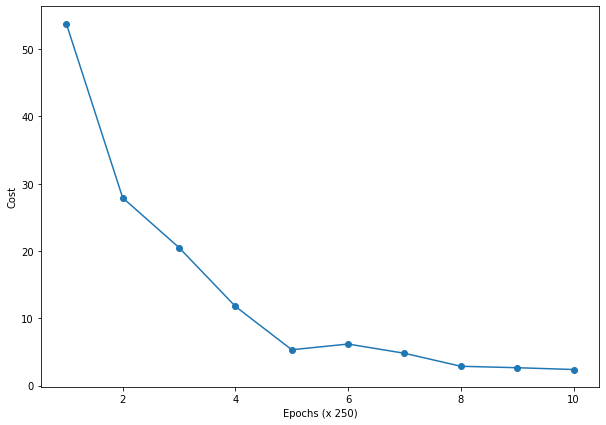

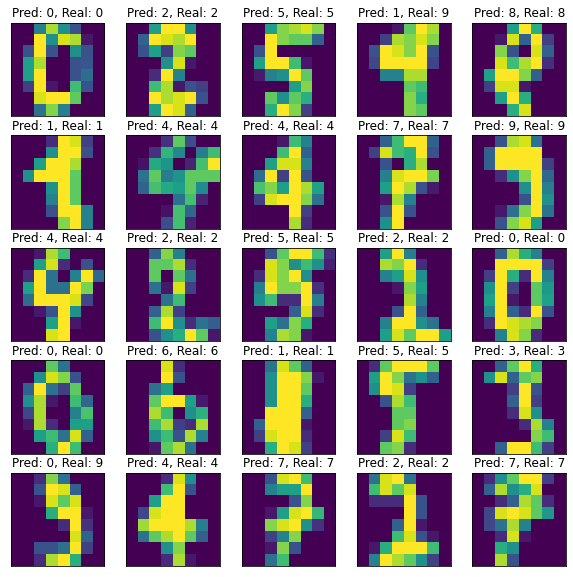

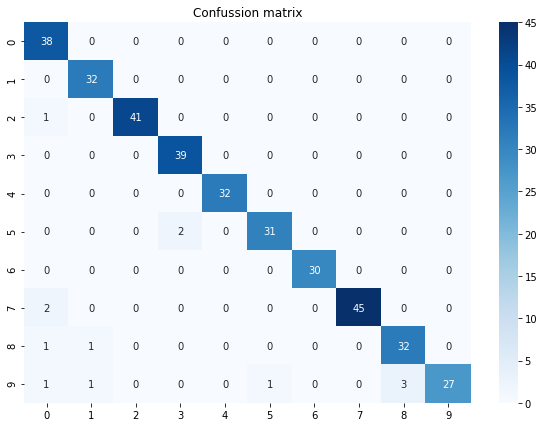

The train accuracy of this model is: 99.9 %
The test accuracy of this model is: 96.39999999999999 %
The necesary time to fit the model has benn: 2.563 seconds


In [7]:
model = load_digits()
x_ms, y_ms = model.data, model.target

neural_info_ms = {'n_iter': 2500, 'eta': 0.005, 'LS': None, 
               'cost': 'logistic', 
               'batch size': 100, 
               'shuffle': True, 'activation': sigmoid, 
               'd_activation': deriv_sigmoid}

set_model_information(x_ms, y_ms, 'short mnist', neural_info=neural_info_ms)

### 2. Tanh activation function

--------------------
Cost 250th epoch:,  199.983
--------------------
--------------------
Cost 500th epoch:,  73.322
--------------------
--------------------
Cost 750th epoch:,  10.425
--------------------
--------------------
Cost 1000th epoch:,  35.407
--------------------
--------------------
Cost 1250th epoch:,  1.543
--------------------
--------------------
Cost 1500th epoch:,  13.548
--------------------
--------------------
Cost 1750th epoch:,  1.021
--------------------
--------------------
Cost 2000th epoch:,  0.832
--------------------
--------------------
Cost 2250th epoch:,  2.804
--------------------
--------------------
Cost 2500th epoch:,  0.627
--------------------


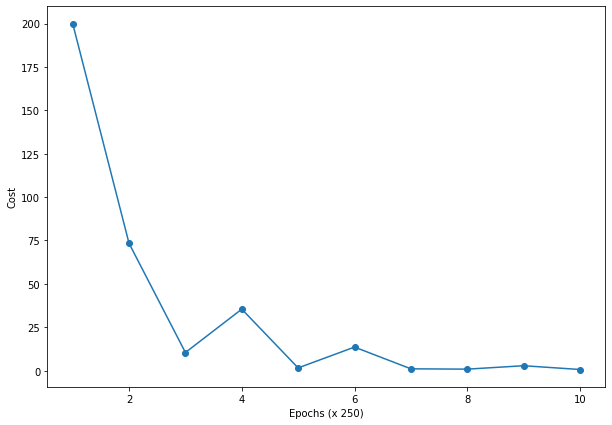

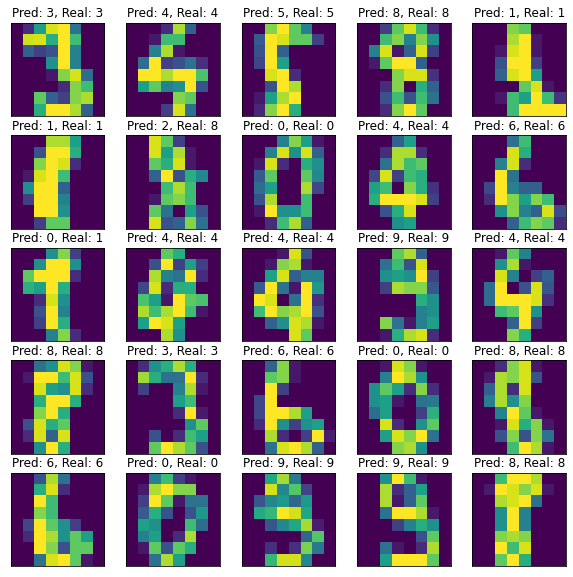

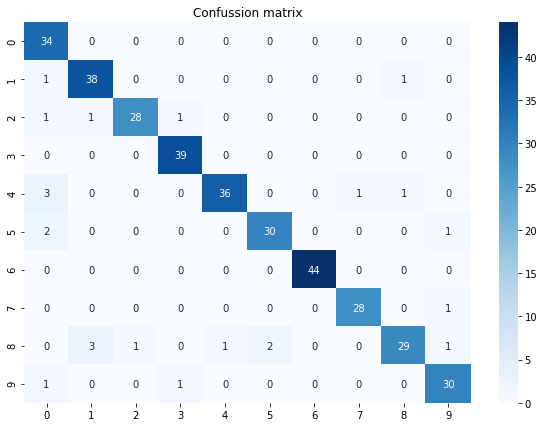

The train accuracy of this model is: 99.7 %
The test accuracy of this model is: 93.30000000000001 %
The necesary time to fit the model has benn: 2.54 seconds


In [8]:
model = load_digits()
x_mt, y_mt = model.data, model.target

neural_info_mt = {'n_iter': 2500, 'eta': 0.005, 'LS': None, 
               'cost': 'logistic', 
               'batch size': 100, 
               'shuffle': True, 'activation': tanh, 
               'd_activation': deriv_tanh}

set_model_information(x_mt, y_mt, 'short mnist', neural_info=neural_info_mt)

# 2. Make blobs

### 1. Sigmoid activation function

--------------------
Cost 30th epoch:,  58.931
--------------------
--------------------
Cost 60th epoch:,  26.856
--------------------
--------------------
Cost 90th epoch:,  16.098
--------------------
--------------------
Cost 120th epoch:,  9.523
--------------------
--------------------
Cost 150th epoch:,  10.15
--------------------
--------------------
Cost 180th epoch:,  7.122
--------------------
--------------------
Cost 210th epoch:,  6.586
--------------------
--------------------
Cost 240th epoch:,  6.642
--------------------
--------------------
Cost 270th epoch:,  9.611
--------------------
--------------------
Cost 300th epoch:,  4.926
--------------------


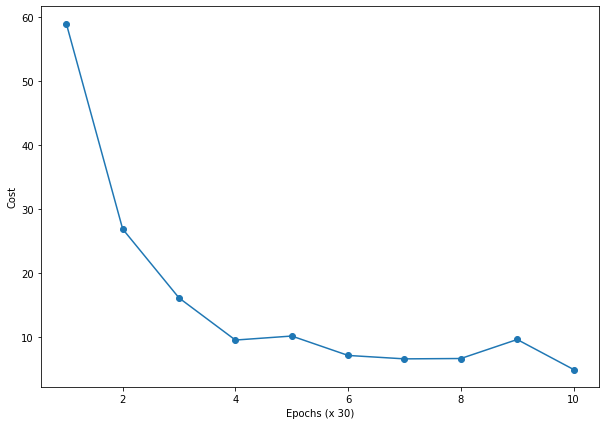

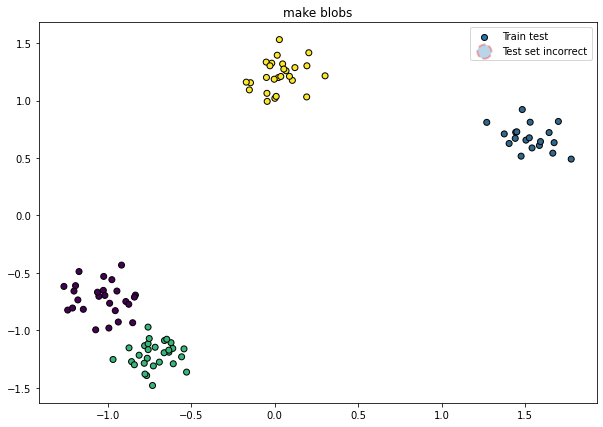

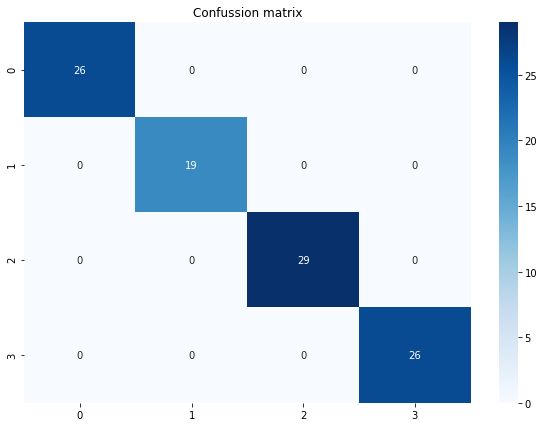

The train accuracy of this model is: 99.0 %
The test accuracy of this model is: 100.0 %
The necesary time to fit the model has benn: 0.203 seconds


In [10]:
x_mbs, y_mbs = make_blobs(n_samples=500, centers=4, cluster_std=0.8)

neural_info_mbs = {'n_iter': 300, 'eta': 0.005, 'LS': None, 
                  'cost': 'logistic', 
                  'batch size': 100, 
                  'shuffle': True, 'activation': sigmoid, 
                  'd_activation': deriv_sigmoid}

set_model_information(x_mbs, y_mbs, 'make blobs', 
                      neural_info=neural_info_mbs, cost_ratio=30, 
                      layers=2, hidden_units=30, Scaler=StandardScaler)

### 2. Tanh activation function

--------------------
Cost 30th epoch:,  5.776
--------------------
--------------------
Cost 60th epoch:,  2.951
--------------------
--------------------
Cost 90th epoch:,  5.385
--------------------
--------------------
Cost 120th epoch:,  10.647
--------------------
--------------------
Cost 150th epoch:,  3.278
--------------------
--------------------
Cost 180th epoch:,  1.111
--------------------
--------------------
Cost 210th epoch:,  0.967
--------------------
--------------------
Cost 240th epoch:,  1.464
--------------------
--------------------
Cost 270th epoch:,  0.863
--------------------
--------------------
Cost 300th epoch:,  0.502
--------------------


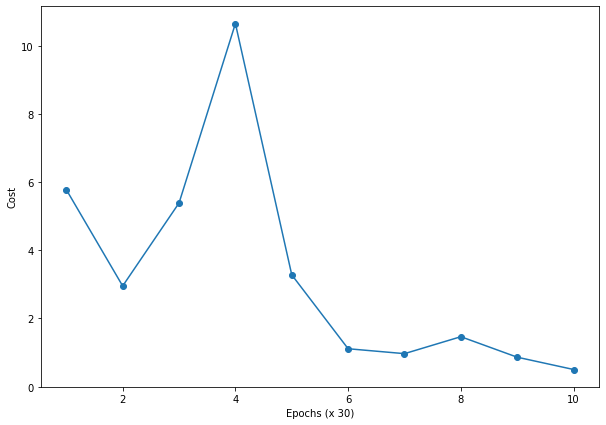

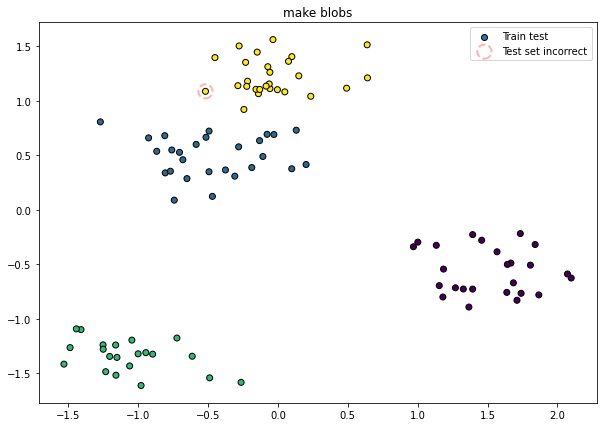

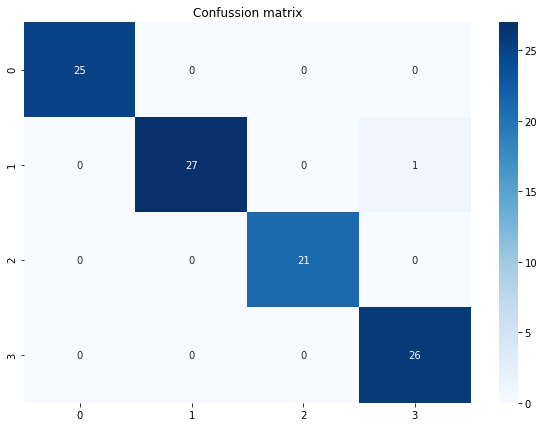

The train accuracy of this model is: 99.2 %
The test accuracy of this model is: 99.0 %
The necesary time to fit the model has benn: 0.183 seconds


In [11]:
x_mbt, y_mbt = make_blobs(n_samples=500, centers=4, cluster_std=1.3)

neural_info_mbt = {'n_iter': 300, 'eta': 0.005, 'LS': None, 
                  'cost': 'logistic', 
                  'batch size': 50, 
                  'shuffle': True, 'activation': tanh, 
                  'd_activation': deriv_tanh}

set_model_information(x_mbt, y_mbt, 'make blobs', 
                      neural_info=neural_info_mbt, cost_ratio=30, 
                      layers=2, hidden_units=40, Scaler=StandardScaler)

# 3. Make moons

### 1. Sigmoid activation function

--------------------
Cost 250th epoch:,  72.423
--------------------
--------------------
Cost 500th epoch:,  0.55
--------------------
--------------------
Cost 750th epoch:,  0.667
--------------------
--------------------
Cost 1000th epoch:,  0.285
--------------------
--------------------
Cost 1250th epoch:,  0.214
--------------------
--------------------
Cost 1500th epoch:,  0.163
--------------------
--------------------
Cost 1750th epoch:,  0.101
--------------------
--------------------
Cost 2000th epoch:,  0.108
--------------------
--------------------
Cost 2250th epoch:,  0.125
--------------------
--------------------
Cost 2500th epoch:,  0.085
--------------------


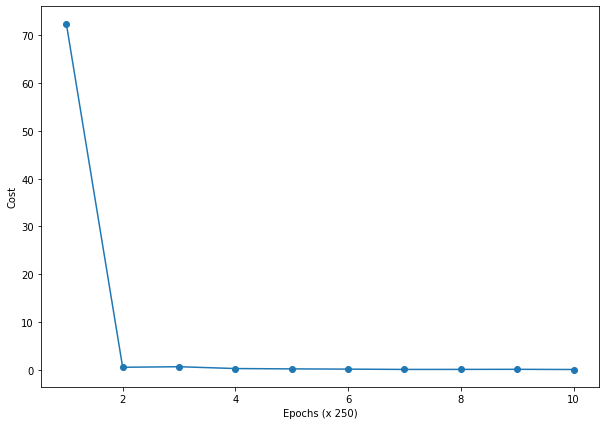

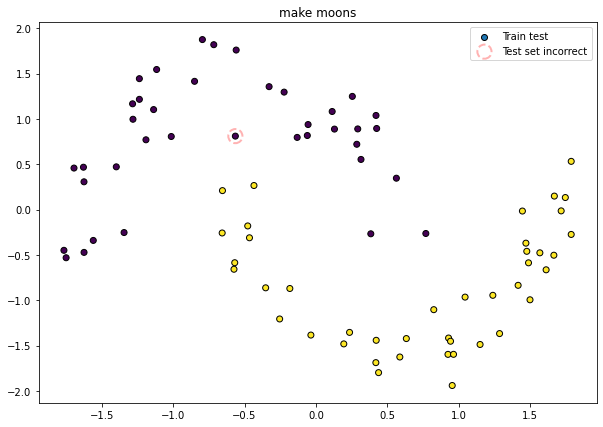

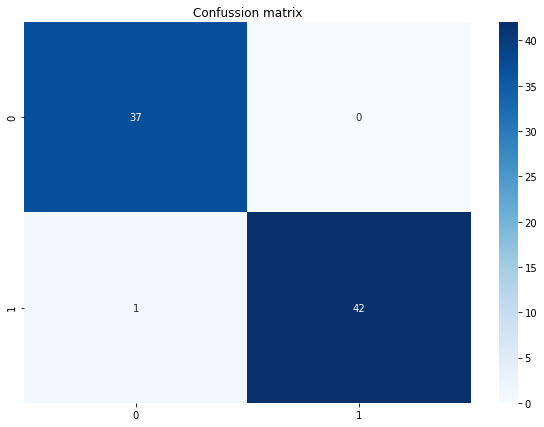

The train accuracy of this model is: 100.0 %
The test accuracy of this model is: 98.8 %
The necesary time to fit the model has benn: 2.09 seconds


In [13]:
x_mms, y_mms = make_moons(n_samples=400, noise=0.1)

neural_info_mms = {'n_iter': 2500, 'eta': 0.005, 'LS': None, 
                  'cost': 'logistic', 
                  'batch size': 100, 
                  'shuffle': True, 'activation': sigmoid, 
                  'd_activation': deriv_sigmoid}

set_model_information(x_mms, y_mms, 'make moons', 
                      neural_info=neural_info_mms, cost_ratio=250, 
                      layers=4, hidden_units=30, Scaler=StandardScaler)

### 2. Tanh activation function

--------------------
Cost 250th epoch:,  0.438
--------------------
--------------------
Cost 500th epoch:,  0.184
--------------------
--------------------
Cost 750th epoch:,  0.11
--------------------
--------------------
Cost 1000th epoch:,  0.125
--------------------
--------------------
Cost 1250th epoch:,  0.063
--------------------
--------------------
Cost 1500th epoch:,  0.077
--------------------
--------------------
Cost 1750th epoch:,  0.056
--------------------
--------------------
Cost 2000th epoch:,  0.065
--------------------
--------------------
Cost 2250th epoch:,  0.035
--------------------
--------------------
Cost 2500th epoch:,  0.046
--------------------


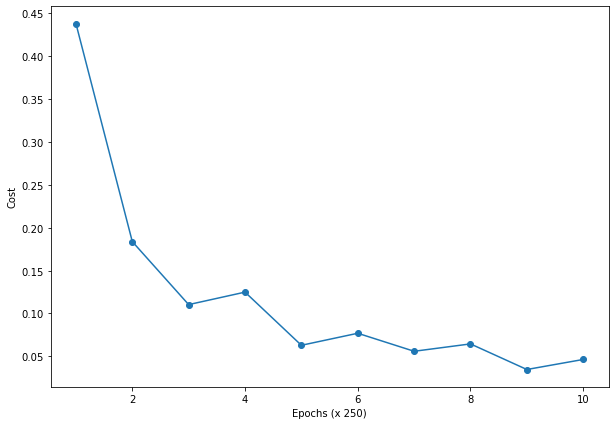

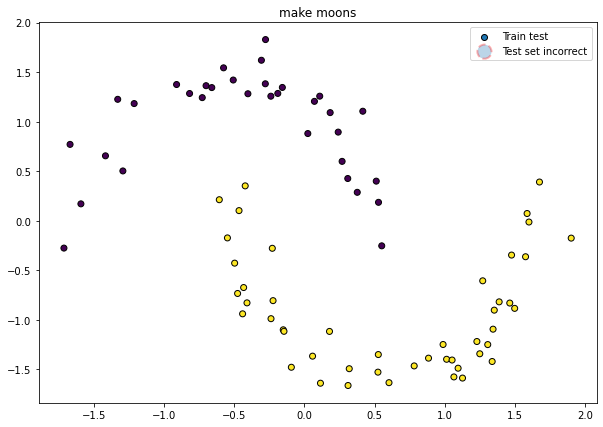

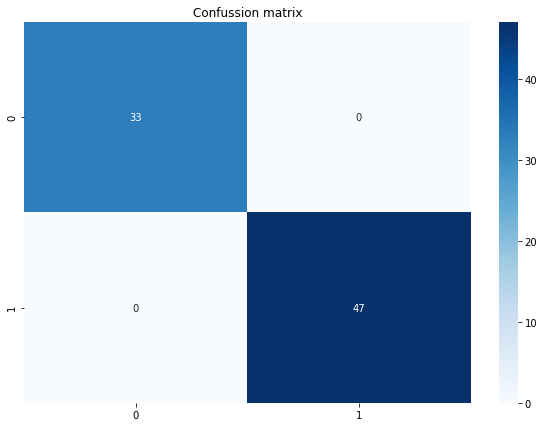

The train accuracy of this model is: 100.0 %
The test accuracy of this model is: 100.0 %
The necesary time to fit the model has benn: 1.311 seconds


In [15]:
x_mmt, y_mmt = make_moons(n_samples=400, noise=0.1)

neural_info_mmt = {'n_iter': 2500, 'eta': 0.005, 'LS': None, 
                  'cost': 'logistic', 
                  'batch size': 100, 
                  'shuffle': True, 'activation': tanh, 
                  'd_activation': deriv_tanh}

set_model_information(x_mmt, y_mmt, 'make moons', 
                      neural_info=neural_info_mmt, cost_ratio=250, 
                      layers=2, hidden_units=30, Scaler=StandardScaler)

# 4. Large Mnist

In [16]:
model = fetch_openml('mnist_784', version=1, as_frame=False)

###  Sigmoid activation function

--------------------
Cost 250th epoch:,  158.16
--------------------
--------------------
Cost 500th epoch:,  101.988
--------------------
--------------------
Cost 750th epoch:,  111.041
--------------------
--------------------
Cost 1000th epoch:,  102.197
--------------------
--------------------
Cost 1250th epoch:,  74.651
--------------------
--------------------
Cost 1500th epoch:,  58.01
--------------------
--------------------
Cost 1750th epoch:,  62.87
--------------------
--------------------
Cost 2000th epoch:,  61.91
--------------------
--------------------
Cost 2250th epoch:,  45.673
--------------------
--------------------
Cost 2500th epoch:,  46.862
--------------------


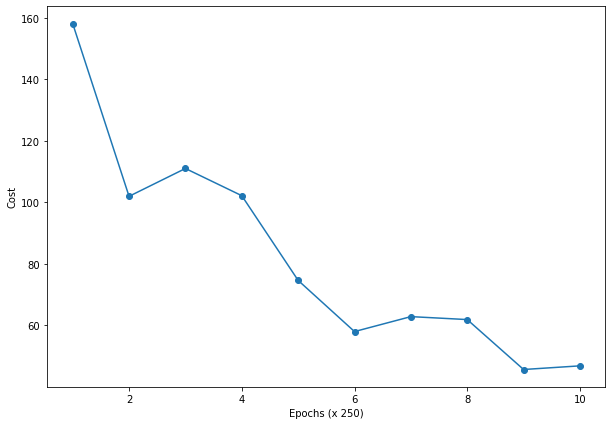

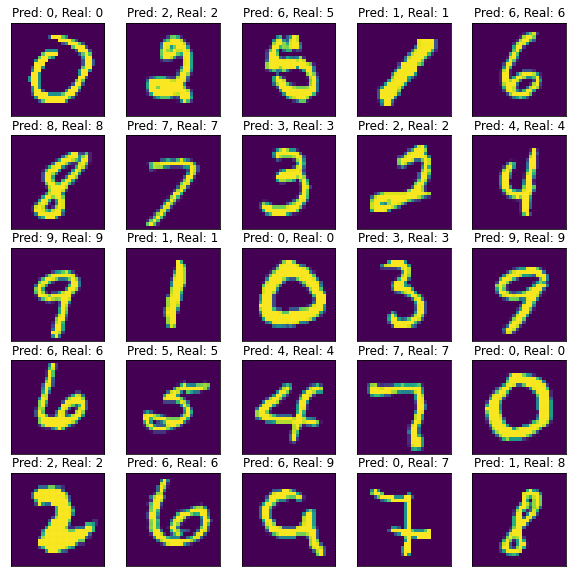

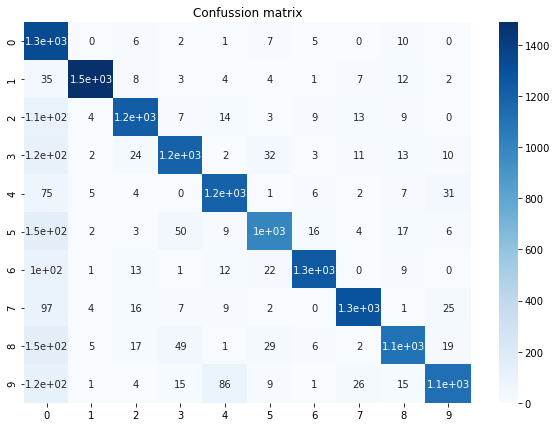

The train accuracy of this model is: 88.7 %
The test accuracy of this model is: 87.5 %
The necesary time to fit the model has benn: 344.182 seconds


In [17]:
x_Ms, y_Ms = model.data, model.target.astype(int)

neural_info_Ms = {'n_iter': 2500, 'eta': 0.005, 'LS': None, 
               'cost': 'logistic', 
               'batch size': 100, 
               'shuffle': True, 'activation': sigmoid, 
               'd_activation': deriv_sigmoid}

set_model_information(x_Ms, y_Ms, 'large mnist', 
                      neural_info=neural_info_Ms, cost_ratio=250)

**Underfitting**